# RNN (Time Series)

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline
# %matplotlib notebook
plt.rcParams["figure.figsize"] = (10,6)
# plt.rcParams['figure.dpi'] = 100
sns.set_style("whitegrid")
import warnings
warnings.filterwarnings("ignore")
warnings.warn("this will not show")
pd.set_option('display.float_format', lambda x: '%.3f' % x)

## Data

Release: Advance Monthly Sales for Retail and Food Services  
Units:  Millions of Dollars, Not Seasonally Adjusted

Frequency:  Monthly

The value for the most recent month is an advance estimate that is based on data from a subsample of firms from the larger Monthly Retail Trade Survey. The advance estimate will be superseded in following months by revised estimates derived from the larger Monthly Retail Trade Survey. The associated series from the Monthly Retail Trade Survey is available at https://fred.stlouisfed.org/series/MRTSSM448USN

Information about the Advance Monthly Retail Sales Survey can be found on the Census website at https://www.census.gov/retail/marts/about_the_surveys.html

Suggested Citation:
U.S. Census Bureau, Advance Retail Sales: Clothing and Clothing Accessory Stores [RSCCASN], retrieved from FRED, Federal Reserve Bank of St. Louis; https://fred.stlouisfed.org/series/RSCCASN, November 16, 2019.

https://fred.stlouisfed.org/series/RSCCASN

In [2]:
df = pd.read_csv('../data&resources/RSCCASN.csv',
                 index_col='DATE',
                 parse_dates=True
                )

In [3]:
df.head()

,RSCCASN
DATE,
1992-01-01,6938
1992-02-01,7524
1992-03-01,8475
1992-04-01,9401
1992-05-01,9558


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 334 entries, 1992-01-01 to 2019-10-01
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype
---  ------   --------------  -----
 0   RSCCASN  334 non-null    int64
dtypes: int64(1)
memory usage: 5.2 KB


In [5]:
df.columns = ['Sales']

<AxesSubplot:xlabel='DATE'>

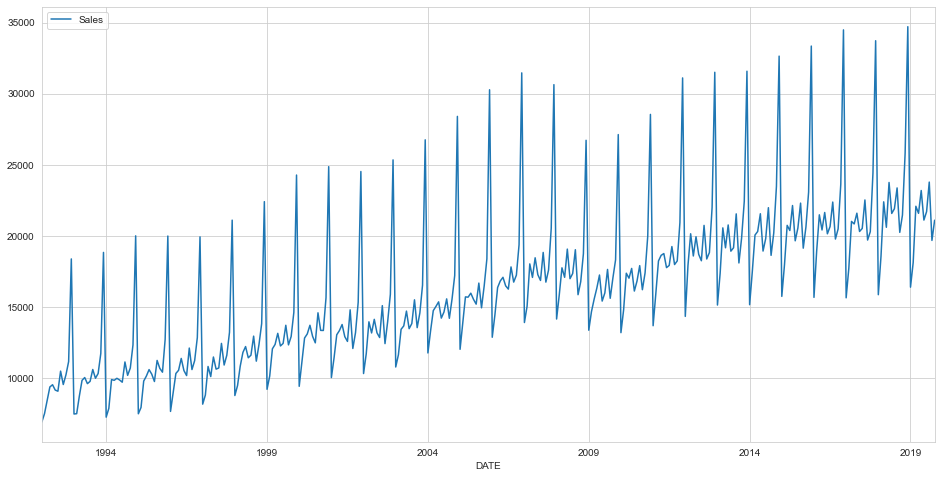

In [6]:
df.plot(figsize=(16,8))

## Preprocessing of Data

### Train Test Split

In [7]:
len(df)

334

In [8]:
len(df)- 18

316

In [9]:
test_size = 18

In [10]:
test_ind = len(df)- test_size

In [11]:
train = df.iloc[:test_ind]
test = df.iloc[test_ind:]

In [12]:
train

,Sales
DATE,
1992-01-01,6938
1992-02-01,7524
1992-03-01,8475
1992-04-01,9401
1992-05-01,9558
...,...
2017-12-01,33720
2018-01-01,15881
2018-02-01,18585


In [13]:
test

,Sales
DATE,
2018-05-01,23764
2018-06-01,21589
2018-07-01,21919
2018-08-01,23381
2018-09-01,20260
2018-10-01,21473
2018-11-01,25831
2018-12-01,34706
2019-01-01,16410


### Scaling

In [14]:
from sklearn.preprocessing import MinMaxScaler

In [15]:
scaler = MinMaxScaler()

In [16]:
train_scaled = scaler.fit_transform(train)
test_scaled = scaler.transform(test)

## Time Series Generator

In [17]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

In [18]:
# help(TimeseriesGenerator)

In [19]:
length = 12
generator = TimeseriesGenerator(train_scaled, train_scaled, length = length, batch_size = 1)

In [20]:
generator[0]

(array([[[0.        ],
         [0.02127505],
         [0.05580163],
         [0.08942056],
         [0.09512053],
         [0.08146965],
         [0.07860151],
         [0.12979233],
         [0.09566512],
         [0.1203892 ],
         [0.15426227],
         [0.41595266]]]),
 array([[0.02047633]]))

In [21]:
X, y = generator[0]

In [22]:
print(f'Given the Array: \n{X.flatten()}')
print(f'Predict this y: \n {y}')

Given the Array: 
[0.         0.02127505 0.05580163 0.08942056 0.09512053 0.08146965
 0.07860151 0.12979233 0.09566512 0.1203892  0.15426227 0.41595266]
Predict this y: 
 [[0.02047633]]


## Modelling

In [23]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM

In [24]:
n_features = 1

In [25]:
model = Sequential()
model.add(LSTM(100, activation = 'relu', input_shape = (length, n_features)))
model.add(Dense(1))
model.compile(optimizer = 'adam', loss = 'mse')

In [26]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 100)               40800     
_________________________________________________________________
dense (Dense)                (None, 1)                 101       
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________


### EarlyStopping and Validation Generator

In [27]:
from tensorflow.keras.callbacks import EarlyStopping

In [28]:
early_stop = EarlyStopping(monitor = 'val_loss', patience = 5)

In [29]:
validation_generator = TimeseriesGenerator(test_scaled, test_scaled, length = length, batch_size = 1)

In [30]:
len(validation_generator)

6

In [31]:
model.fit_generator(generator, epochs = 20,
                    validation_data = validation_generator,
                    callbacks = [early_stop])

Epoch 1/20
304/304 [==============================] - 3s 5ms/step - loss: 0.0302 - val_loss: 0.0026
Epoch 2/20
304/304 [==============================] - 1s 4ms/step - loss: 0.0172 - val_loss: 0.0021
Epoch 3/20
304/304 [==============================] - 1s 4ms/step - loss: 0.0111 - val_loss: 0.0193
Epoch 4/20
304/304 [==============================] - 1s 4ms/step - loss: 0.0051 - val_loss: 0.0120
Epoch 5/20
304/304 [==============================] - 1s 4ms/step - loss: 0.0034 - val_loss: 8.1124e-04
Epoch 6/20
304/304 [==============================] - 1s 4ms/step - loss: 0.0019 - val_loss: 0.0026
Epoch 7/20
304/304 [==============================] - 1s 5ms/step - loss: 0.0024 - val_loss: 8.1826e-04
Epoch 8/20
304/304 [==============================] - 1s 5ms/step - loss: 0.0021 - val_loss: 0.0034
Epoch 9/20
304/304 [==============================] - 2s 5ms/step - loss: 0.0012 - val_loss: 2.8966e-04
Epoch 10/20
304/304 [==============================] - 2s 5ms/step - loss: 0.0011 - val_

<AxesSubplot:>

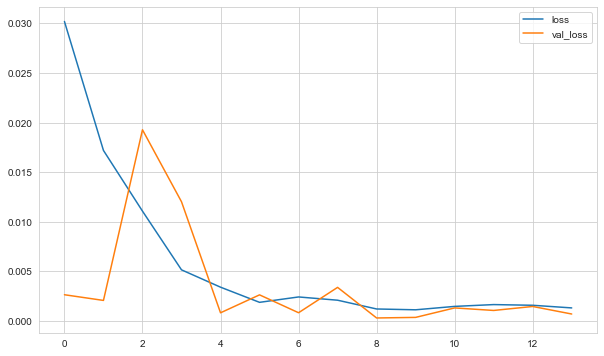

In [32]:
loss_df = pd.DataFrame(model.history.history)
loss_df.plot()

## Evaluate on Test Data

In [33]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [34]:
def eval_metrics(actual, pred):
    rmse = np.sqrt(mean_squared_error(actual, pred))
    mae = mean_absolute_error(actual, pred)
    mse = mean_squared_error(actual, pred)
    score = r2_score(actual, pred)
    return print("r2_score:", score, "\n","mae:", mae, "\n","mse:",mse, "\n","rmse:",rmse)

In [35]:
y_pred = model.predict(validation_generator)

In [36]:
y_pred

array([[0.61670756],
       [0.5408755 ],
       [0.5527758 ],
       [0.60333055],
       [0.5029563 ],
       [0.5437405 ]], dtype=float32)

In [37]:
test_scaled[-6:]

array([[0.59040081],
       [0.51499419],
       [0.53645077],
       [0.61185739],
       [0.46314987],
       [0.51463114]])

In [38]:
eval_metrics(test_scaled[-6:], y_pred)

r2_score: 0.722226482130795 
 mae: 0.02432595008005183 
 mse: 0.0006888343230048257 
 rmse: 0.026245653411657056


In [39]:
test_predictions = []

first_eval_batch = train_scaled[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(len(test)):
    
    # get prediction 1 time stamp ahead
    current_pred = model.predict(current_batch)[0]
    
    # store prediction
    test_predictions.append(current_pred) 
    
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:, 1:, :], [[current_pred]], axis=1)

In [41]:
eval_metrics(test_scaled, test_predictions)

r2_score: 0.9479196987614463 
 mae: 0.025219705836195174 
 mse: 0.0009180263903335087 
 rmse: 0.030298950317354374


### Inverse Transformations and Comparing

In [42]:
true_predictions = scaler.inverse_transform(test_predictions)

In [43]:
test['Predictions'] = true_predictions

In [44]:
test

,Sales,Predictions
DATE,,
2018-05-01,23764,21827.687
2018-06-01,21589,20672.805
2018-07-01,21919,20878.435
2018-08-01,23381,22702.336
2018-09-01,20260,20252.465
2018-10-01,21473,20826.481
2018-11-01,25831,24813.760
2018-12-01,34706,34469.329
2019-01-01,16410,16544.659


<AxesSubplot:xlabel='DATE'>

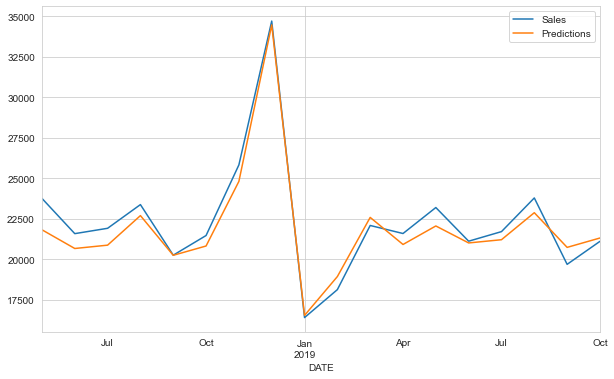

In [45]:
test.plot()

In [46]:
eval_metrics(test.Sales, test.Predictions)

r2_score: 0.9479196987614461 
 mae: 694.651577552161 
 mse: 696480.8588534174 
 rmse: 834.5542875412104


## Retrain and Forecasting

In [47]:
full_scaler = MinMaxScaler()
scaled_full_data = full_scaler.fit_transform(df)

In [48]:
length = 12 
generator = TimeseriesGenerator(scaled_full_data, scaled_full_data, length = length, batch_size = 1)

In [49]:
model = Sequential()
model.add(LSTM(100, activation = 'relu', input_shape = (length, n_features)))
model.add(Dense(1))
model.compile(optimizer = 'adam', loss = 'mse')

model.fit_generator(generator, epochs=15)

Epoch 1/15
322/322 [==============================] - 2s 4ms/step - loss: 0.0289
Epoch 2/15
322/322 [==============================] - 1s 4ms/step - loss: 0.0174
Epoch 3/15
322/322 [==============================] - 1s 4ms/step - loss: 0.0140
Epoch 4/15
322/322 [==============================] - 1s 4ms/step - loss: 0.0059
Epoch 5/15
322/322 [==============================] - 1s 4ms/step - loss: 0.0022
Epoch 6/15
322/322 [==============================] - 1s 4ms/step - loss: 0.0017
Epoch 7/15
322/322 [==============================] - 1s 4ms/step - loss: 0.0029
Epoch 8/15
322/322 [==============================] - 1s 4ms/step - loss: 0.0015
Epoch 9/15
322/322 [==============================] - 2s 5ms/step - loss: 0.0018
Epoch 10/15
322/322 [==============================] - 2s 5ms/step - loss: 0.0017
Epoch 11/15
322/322 [==============================] - 2s 5ms/step - loss: 0.0017
Epoch 12/15
322/322 [==============================] - 1s 5ms/step - loss: 0.0011
Epoch 13/15
322/322 [====

In [50]:
scaled_full_data.shape

(334, 1)

In [51]:
scaled_full_data[-length:].shape

(12, 1)

In [74]:
forecast = []
# Replace periods with whatever forecast length you want
periods = 12

first_eval_batch = scaled_full_data[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(periods):
    
    # get prediction 1 time stamp ahead ([0] is for grabbing just the number instead of [array])
    current_pred = model.predict(current_batch)[0]
    
    # store prediction
    forecast.append(current_pred) 
    
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:, 1:, :], [[current_pred]], axis = 1)

In [75]:
forecast = scaler.inverse_transform(forecast)

In [76]:
forecast

array([[25133.98030233],
       [34200.90443277],
       [16262.36371708],
       [18126.61226702],
       [21291.82975197],
       [20978.00096655],
       [22380.00650072],
       [20569.30856323],
       [21071.21790886],
       [22795.40873766],
       [19414.30600882],
       [20517.61641216]])

In [77]:
df

,Sales
DATE,
1992-01-01,6938
1992-02-01,7524
1992-03-01,8475
1992-04-01,9401
1992-05-01,9558
...,...
2019-06-01,21123
2019-07-01,21714
2019-08-01,23791


In [78]:
forecast_index = pd.date_range(start = '2019-11-01', periods = periods, freq = 'MS')

https://stackoverflow.com/questions/35339139/what-values-are-valid-in-pandas-freq-tags

In [79]:
forecast_index

DatetimeIndex(['2019-11-01', '2019-12-01', '2020-01-01', '2020-02-01',
               '2020-03-01', '2020-04-01', '2020-05-01', '2020-06-01',
               '2020-07-01', '2020-08-01', '2020-09-01', '2020-10-01'],
              dtype='datetime64[ns]', freq='MS')

In [80]:
forecast_df = pd.DataFrame(data = forecast, index = forecast_index, columns = ['Forecast'])

In [81]:
forecast_df

,Forecast
2019-11-01,25133.980
2019-12-01,34200.904
2020-01-01,16262.364
2020-02-01,18126.612
2020-03-01,21291.830
2020-04-01,20978.001
2020-05-01,22380.007
2020-06-01,20569.309
2020-07-01,21071.218
2020-08-01,22795.409


<AxesSubplot:>

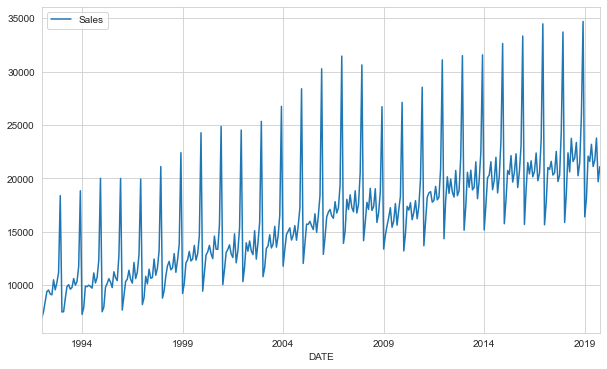

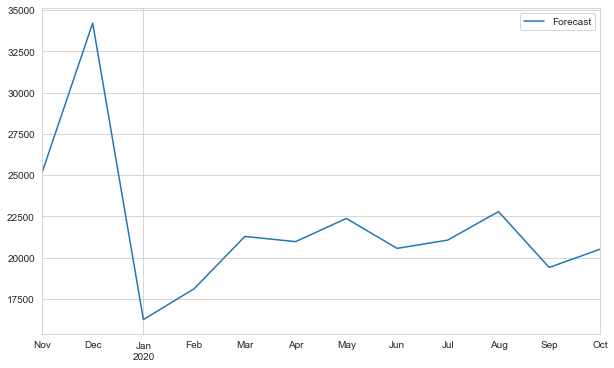

In [82]:
df.plot()
forecast_df.plot()

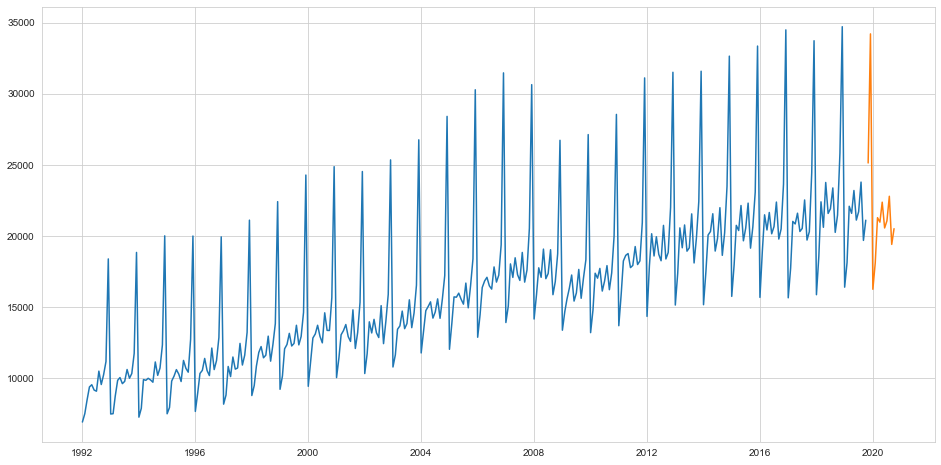

In [83]:
plt.figure(figsize = (16, 8))
plt.plot(df.index, df['Sales'])
plt.plot(forecast_df.index, forecast_df['Forecast'])
#plt.plot(forecast_index, forecast)

### Joining pandas plots

https://stackoverflow.com/questions/13872533/plot-different-dataframes-in-the-same-figure

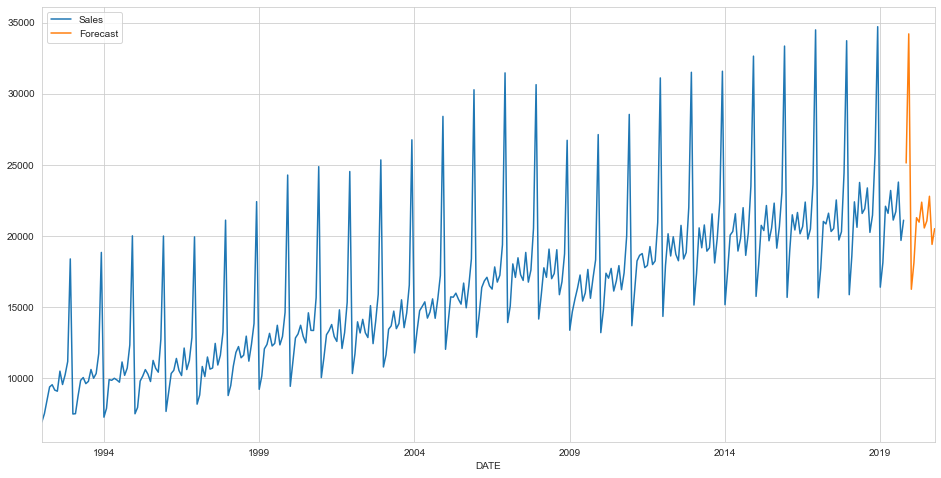

In [84]:
ax = df.plot()
forecast_df.plot(ax = ax, figsize = (16, 8));

(576.0, 611.0)

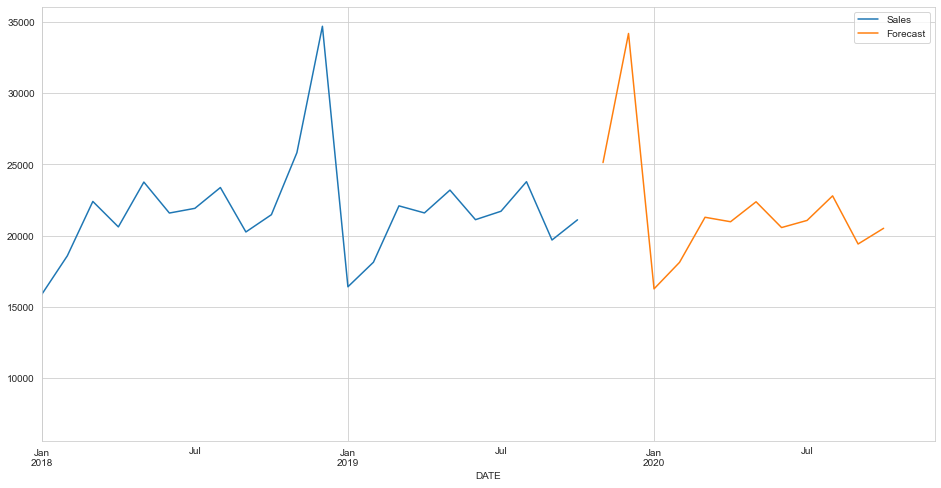

In [85]:
ax = df.plot()
forecast_df.plot(ax = ax, figsize = (16, 8))
plt.xlim('2018-01-01', '2020-12-01')